In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
from torch.cuda.amp import autocast, GradScaler
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    device = torch.device("cpu")
    print("GPU 不可用，将在 CPU 上运行")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
torch.cuda.empty_cache()  # 释放显存

# 定义标准化函数
def normalize_row(row):
    data = row.dropna()
    mean = np.mean(data)
    std = np.std(data)
    row[row.notna()] = (row[row.notna()] - mean) / std
    return row

cuda


In [3]:

#因子正交
class MyModelZJ(nn.Module):
    def __init__(self, input_size,num_factors, num_stocks):  #提取因子个数
        super(MyModelZJ, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
               
        # 定义全连接层
        self.fc = nn.Linear(input_size, num_factors)  #
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #

    def forward(self, x):
        batch_size, _, num_features = x.size()
        x = x.view(-1, num_features)
        # 全连接层
        fc_out = self.fc(x)
        fc_out=fc_out.view(batch_size*self.num_stocks,self.num_factors)
        factor_output = self.bn(fc_out)
        factor_output = factor_output.view(batch_size, self.num_stocks, self.num_factors)
        return factor_output


In [5]:
df20=pd.read_feather('/data/disk4/output_stocks/jmchen/factors/ML/combine20.feather')
df21=pd.read_feather('/data/disk4/output_stocks/jmchen/factors/ML/combine21.feather')
df=pd.concat([df20,df21],join='inner',axis=0)
df=df.drop('level_0',axis=1)
index_counts = df['index'].value_counts()
index_counts=index_counts[index_counts==index_counts.max()]
# print(index_counts)
dfx=df[df['index'].isin(index_counts.index)]
dfx=dfx.fillna(0)
ds=dfx.groupby('tradingday')
days=index_counts.max()
num_stocks=len(index_counts)
num_features=4370
X = torch.zeros((days, num_stocks, num_features))
Y = torch.zeros((days, num_stocks))
i=0
day_list=[]
code_list=[]
for day,df in ds:
    print(day,i)
    if i==0:
        code_list=df['index'].to_list()
    df=df.set_index('index')
    x= df.drop(columns=['tradingday','ret'])
    X[i]=torch.Tensor(x.values)
    y=df['ret']
    Y[i]=torch.Tensor(y.values)
    if i>=400:
        day_list.append(day)
    i+=1

X_train=X[:400]
X_test=X[400:]
Y_train=Y[:400]
Y_test=Y[400:]

2020-01-02 0
2020-01-03 1
2020-01-06 2
2020-01-07 3
2020-01-08 4
2020-01-09 5
2020-01-10 6
2020-01-13 7
2020-01-14 8
2020-01-15 9
2020-01-16 10
2020-01-17 11
2020-01-20 12
2020-01-21 13
2020-01-22 14
2020-01-23 15
2020-02-03 16
2020-02-04 17
2020-02-05 18
2020-02-06 19
2020-02-07 20
2020-02-10 21
2020-02-11 22
2020-02-12 23
2020-02-13 24
2020-02-14 25
2020-02-17 26
2020-02-18 27
2020-02-19 28
2020-02-20 29
2020-02-21 30
2020-02-24 31
2020-02-25 32
2020-02-26 33
2020-02-27 34
2020-02-28 35
2020-03-02 36
2020-03-03 37
2020-03-04 38
2020-03-05 39
2020-03-06 40
2020-03-09 41
2020-03-10 42
2020-03-11 43
2020-03-12 44
2020-03-13 45
2020-03-16 46
2020-03-17 47
2020-03-18 48
2020-03-19 49
2020-03-20 50
2020-03-23 51
2020-03-24 52
2020-03-25 53
2020-03-26 54
2020-03-27 55
2020-03-30 56
2020-03-31 57
2020-04-01 58
2020-04-02 59
2020-04-03 60
2020-04-07 61
2020-04-08 62
2020-04-09 63
2020-04-10 64
2020-04-13 65
2020-04-14 66
2020-04-15 67
2020-04-16 68
2020-04-17 69
2020-04-20 70
2020-04-21 71
20

In [6]:
def custom_loss(y, factor_output,k):  #惩罚项系数k
    c = factor_output.mean(dim=2)
    corr=[]
    for i in range(c.shape[0]): #batch内循环
        mean_c = torch.mean(c[i])
        mean_y = torch.mean(y[i])
        
        # Calculate the numerator and denominators for Pearson correlation
        numerator = torch.sum((c[i] - mean_c) * (y[i] - mean_y))
        denominator_c = torch.sqrt(torch.sum((c[i] - mean_c)**2))
        denominator_y = torch.sqrt(torch.sum((y[i] - mean_y)**2))
        # Calculate the Pearson correlation coefficient
        pearson_corr = numerator / (denominator_c * denominator_y)
        corr.append(pearson_corr)
    corr=torch.stack(corr).mean()
    penalty=[]
    for i in range(factor_output.shape[0]): #batch内循环
        correlation_matrix = torch.corrcoef(factor_output[i].T)
        # 将对角线元素设置为零，即将每列与自身的相关系数剔除
        for i in range(factor_output.shape[2]):
            correlation_matrix[i, i] = 0
        # 计算相关系数矩阵的L2范数
        zsum = torch.sum(correlation_matrix**2)
        penalty.append(zsum)
    penalty=torch.stack(penalty).mean().sqrt()
    loss=-corr+k*penalty
    return loss

def custom_loss_f(y, factor_output,k):  #惩罚项系数k
    c = factor_output.mean(dim=2)
    corr=[]
    for i in range(c.shape[0]): #batch内循环
        mean_c = torch.mean(c[i])
        mean_y = torch.mean(y[i])
        
        # Calculate the numerator and denominators for Pearson correlation
        numerator = torch.sum((c[i] - mean_c) * (y[i] - mean_y))
        denominator_c = torch.sqrt(torch.sum((c[i] - mean_c)**2))
        denominator_y = torch.sqrt(torch.sum((y[i] - mean_y)**2))
        # Calculate the Pearson correlation coefficient
        pearson_corr = numerator / (denominator_c * denominator_y)
        corr.append(pearson_corr)
    corr=torch.stack(corr).mean()
    penalty=[]
    for i in range(factor_output.shape[0]): #batch内循环
        correlation_matrix = torch.corrcoef(factor_output[i].T)
        # 将对角线元素设置为零，即将每列与自身的相关系数剔除
        frobenius_norm = torch.norm(correlation_matrix, p='fro')
        penalty.append(frobenius_norm)
    penalty=torch.stack(penalty).mean()
    loss=-corr+k*penalty
    return loss

In [12]:

# num_stocks = 4470
# num_features = 4320
num_epochs = 100
batch_size = 8

input_size = num_features
num_factors = 300  

model = MyModelZJ(input_size, num_factors, num_stocks)
model.to(device)  # 将模型移动到GPU

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.1)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=1)

# 训练模型
loss_history = []
count=0
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-batch_size, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # 计算损失函数
        loss = custom_loss_f(labels, outputs,1)
        # print(loss)
        # print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} loss={np.mean(loss_epoch)}- Learning Rate: {current_lr}")

        #若loss比前一轮大则结束
    if epoch>=3 :
        if (loss.item()/num_stocks)>last:
            count+=1
            if count>=3:
                print('不收敛')
                break
    last=loss.item()/num_stocks

Epoch 1 loss=0.08586206355635159- Learning Rate: 0.1
Epoch 2 loss=0.07845396031419105- Learning Rate: 0.1
Epoch 3 loss=0.06822487228782136- Learning Rate: 0.1
Epoch 4 loss=0.05805931770235394- Learning Rate: 0.1
Epoch 5 loss=0.04929655648426665- Learning Rate: 0.1
Epoch 6 loss=0.04276246776486674- Learning Rate: 0.1
Epoch 7 loss=0.0380455691556162- Learning Rate: 0.1
Epoch 8 loss=0.03451053936960685- Learning Rate: 0.1
Epoch 9 loss=0.03167900938438535- Learning Rate: 0.1
Epoch 10 loss=0.029273073351257277- Learning Rate: 0.1
Epoch 11 loss=0.027174912937788096- Learning Rate: 0.1
Epoch 12 loss=0.02534800489037416- Learning Rate: 0.1
Epoch 13 loss=0.023779594046809995- Learning Rate: 0.1
Epoch 14 loss=0.022429468335167735- Learning Rate: 0.1
Epoch 15 loss=0.021238365614720058- Learning Rate: 0.1
Epoch 16 loss=0.020153666179906823- Learning Rate: 0.1
Epoch 17 loss=0.01914115528384225- Learning Rate: 0.1
Epoch 18 loss=0.018187802303645997- Learning Rate: 0.1
Epoch 19 loss=0.017291784043376

In [ ]:
num_epochs = 100
batch_size = 4

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
# 模型构建

# 创建模型实例
input_size = num_features
num_factors = 400  

model = MyModelZJ(input_size, num_factors, num_stocks)
model.to(device)  # 将模型移动到GPU

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=1)

# 训练模型
loss_history = []
count=0
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-batch_size, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # 计算损失函数
        loss = custom_loss(labels, outputs,0.1)
        # print(loss)
        # print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} loss={np.mean(loss_epoch)}- Learning Rate: {current_lr}")

        #若loss比前一轮大则结束
    if epoch>=3 :
        if (loss.item()/num_stocks)>last:
            count+=1
            if count>=3:
                print('不收敛')
                break
    last=loss.item()/num_stocks

In [13]:
torch.save(model.state_dict(), '/data/disk4/output_stocks/jmchen/factors/ML/zj_model/test.pth')

In [14]:
model = MyModelZJ(num_features, 300, num_stocks)
# 加载保存的模型参数
model_path='/data/disk4/output_stocks/jmchen/factors/ML/zj_model/test.pth'
model.load_state_dict(torch.load(model_path))
# 设置模型为评估模式
model.eval()

with torch.no_grad():
    input_sample = X_test  # 获取单个样本并添加批次维度
    label_sample = Y_test
    # 使用模型进行推理并获取单个样本的预测输出（c值）
    factors = model(input_sample)
    c_value=factors.mean(dim=2)
    print(c_value.shape)
    print(label_sample.shape)

    
dff=pd.DataFrame(c_value.numpy())
dff.columns=code_list
dff.index=day_list
dff.to_csv('/data/disk4/output_stocks/jmchen/factors/ML/extract21_f.csv')

torch.Size([86, 3002])
torch.Size([86, 3002])


加载回测环境
保存回测环境
清洗因子数据并匹配收益率
加载因子数据
计算不同期限的未来收益率
因子分组
env success
因子IC分析
            IC
2021 -0.028365
因子分组表现
因子分组收益图
因子净值曲线
因子分布
因子覆盖度
因子多空表现
因子IC分析
            IC
2021 -0.028365
合并为PDF
(960, 720) 2021_因子净值曲线.png
(579, 121) 因子IC分析.png
(960, 720) 因子净值曲线.png
(1000, 700) 因子分布.png
(640, 480) 因子分组净值-1.png
(640, 480) 因子分组净值-10.png
(640, 480) 因子分组净值-20.png
(640, 480) 因子分组净值-5.png
(1258, 551) 因子分组收益图.png
(1178, 272) 因子多空表现.png
(1161, 272) 因子表现-1.png
(1161, 272) 因子表现-10.png
(1161, 272) 因子表现-20.png
(1161, 272) 因子表现-5.png
(1000, 700) 因子覆盖度.png
(704, 528) 因子逐年IC.png


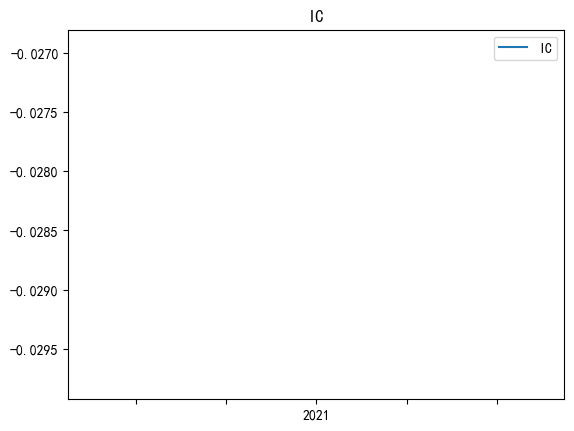

<Figure size 1000x200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

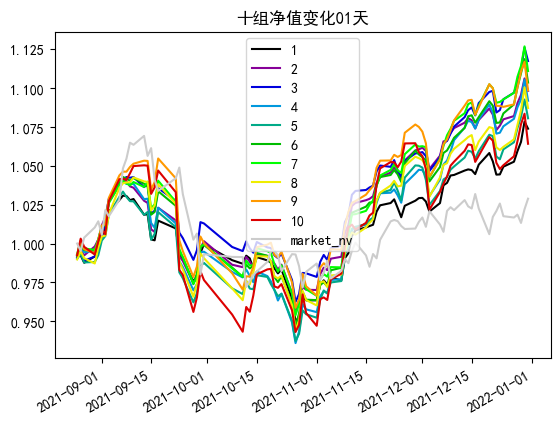

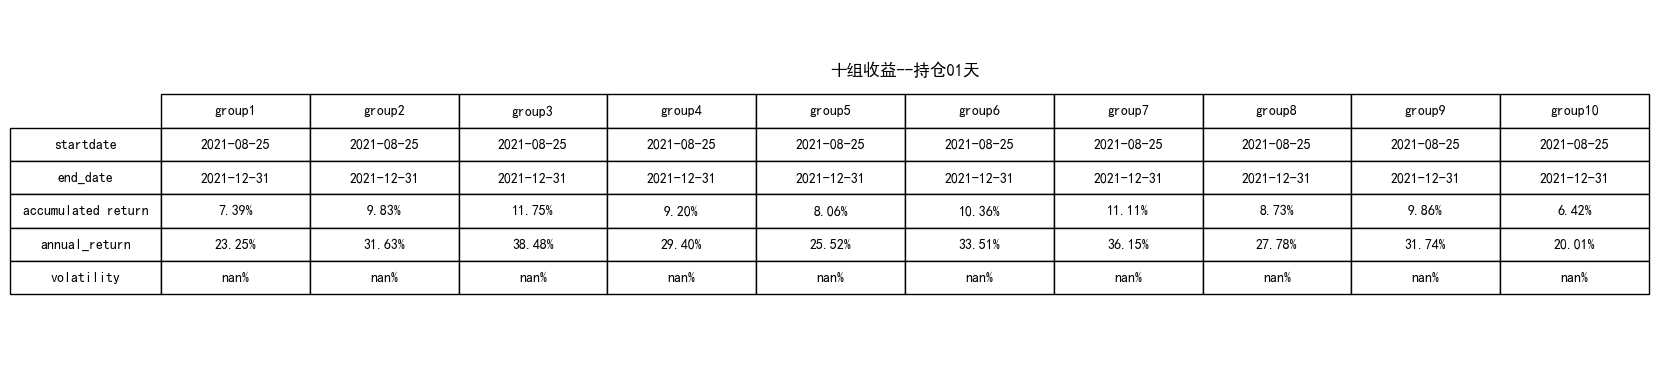

<Figure size 640x480 with 0 Axes>

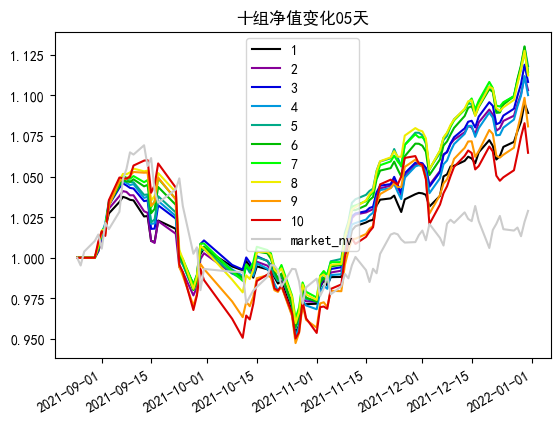

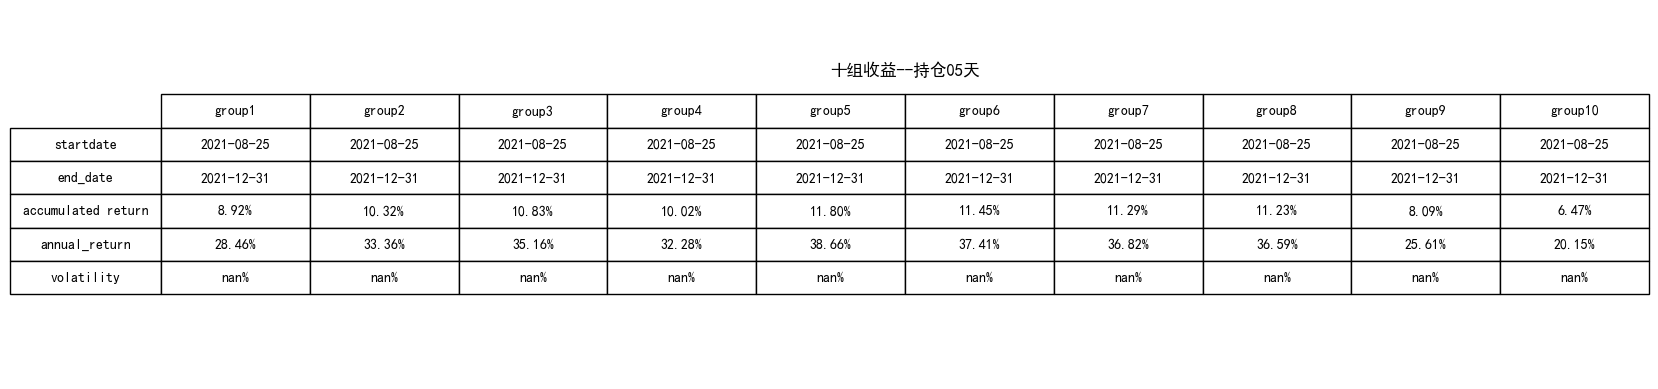

<Figure size 640x480 with 0 Axes>

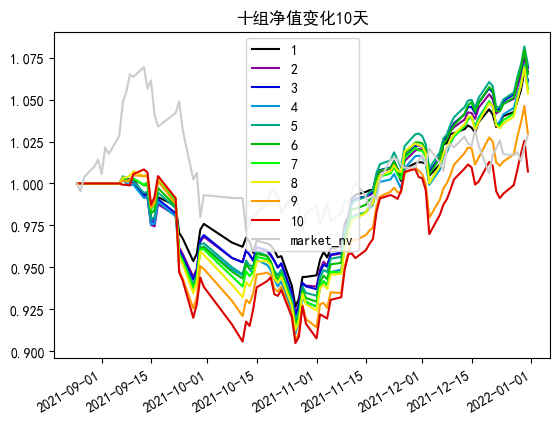

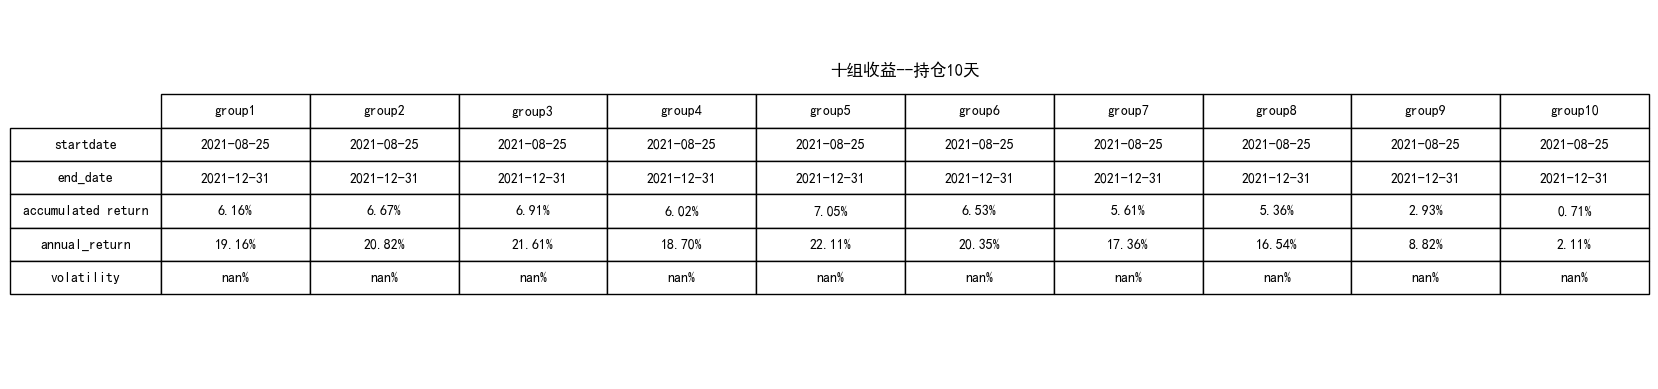

<Figure size 640x480 with 0 Axes>

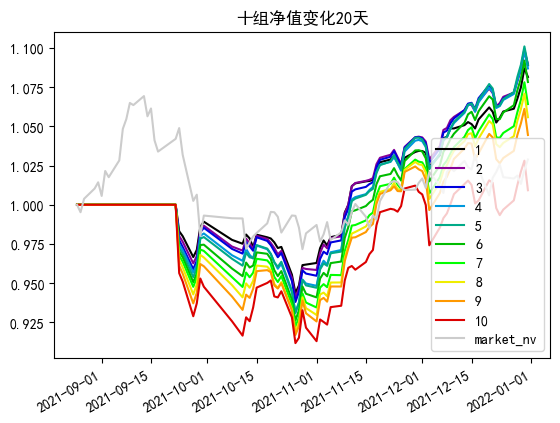

<Figure size 640x480 with 0 Axes>

<Figure size 1800x800 with 0 Axes>

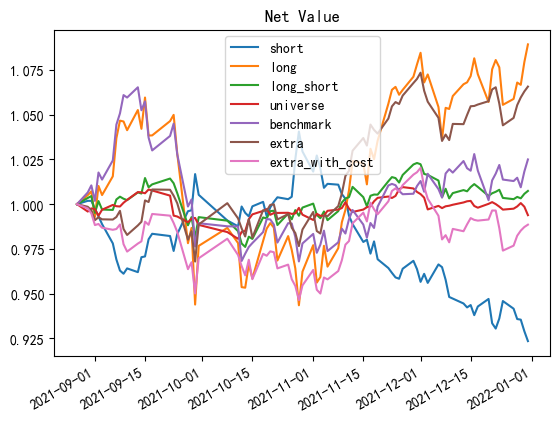

<Figure size 640x480 with 0 Axes>

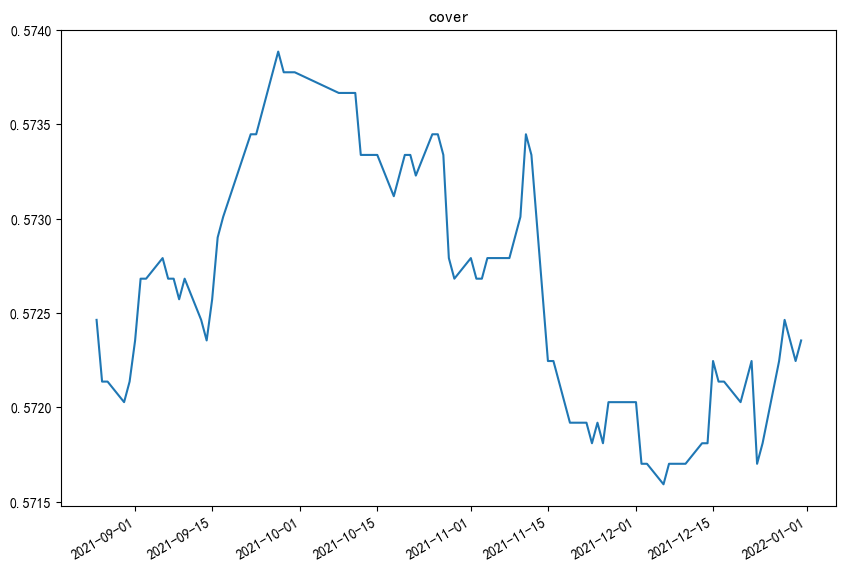

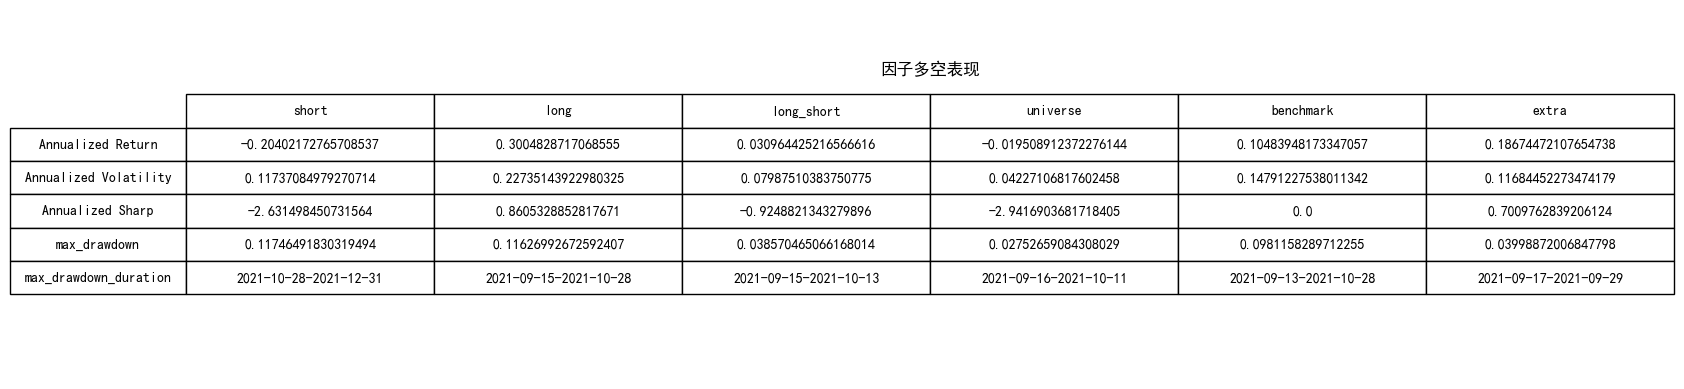

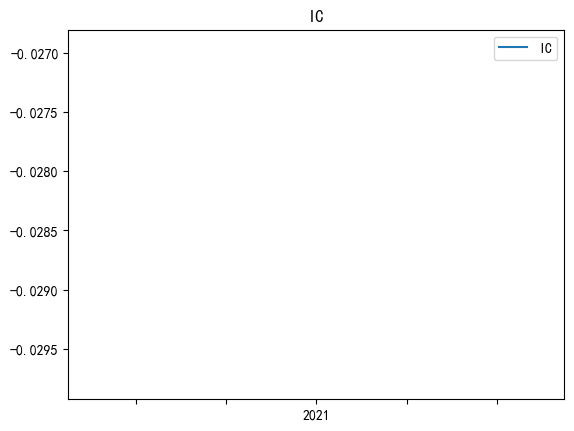

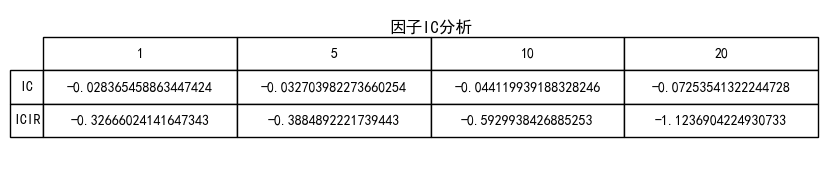

In [15]:
import sys
import seaborn as sns
sys.path.append("/data/disk4/output_stocks/jmchen/backtool")
from factor_backtest import *
factor_path = "/data/disk4/output_stocks/jmchen/factors/ML/extract21_f.csv"
factor_name = 'extract21_f'
result_path = "/data/disk4/output_stocks/jmchen/factors/ML/performance/"
env_path = "/data/disk4/output_stocks/jmchen/backtool/"
os.makedirs(result_path, exist_ok = True)
# factor = pd.read_feather(factor_path).set_index(['ds'])
factor = pd.read_csv(factor_path, index_col=0)
factor.index = pd.to_datetime(factor.index.astype('str'))
factor = 1 * factor.replace(np.inf, np.nan)
# factor = factor.rolling(window=20, min_periods=15).mean()
# factor = factor.loc['2016-01-01':'2022-01-01']
env = Environment(
                    factor_name = factor_name,
                    factor = factor,
                    holding_periods = [1,5,10,20], 
                    save_path = result_path, 
                    env_pkl_path = env_path,
                    method='load',
                    # if_neutral=['indes','size']
                    )
env.run_all()

funs = Functions(env)
funs.ic_calculating()
funs.run_all()
perform = Performance(result_path + factor_name)
perform.render()

In [9]:
torch.cuda.empty_cache()

In [ ]:

from torch.optim import lr_scheduler
from itertools import product


def train_and_save_model(X_train, Y_train, num_factors, lr, batch_size, k, num_epochs):
    print( num_factors, lr, batch_size, k)
    input_size = num_features
    model = MyModelZJ(input_size, num_factors, num_stocks)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=1)
    
    loss_history = []
    count = 0
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        loss_epoch = []
        for i in range(0, X_train.size(0) - batch_size, batch_size):
            inputs = X_train[i:i + batch_size].to(device)
            labels = Y_train[i:i + batch_size].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = custom_loss(labels, outputs, k)
            loss_epoch.append(loss.item() / num_stocks)
            loss.backward()
            optimizer.step()
        
        loss_history.append(np.mean(loss_epoch))
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1} loss={np.mean(loss_epoch)} - Learning Rate: {current_lr}")
        
        if epoch >= 3:
            if (loss.item() / num_stocks) > last:
                count += 1
                if count >= 3:
                    print('不收敛')
                    break
        last = loss.item() / num_stocks

    # 保存模型
    model_filename = f"model_num_factors_{num_factors}_lr_{lr}_batch_{batch_size}_k_{k}.pt"
    model_filepath = os.path.join("/data/disk4/output_stocks/jmchen/factors/ML/zj_model", model_filename)
    torch.save(model.state_dict(), model_filepath)
    torch.cuda.empty_cache()
    return np.mean(loss_epoch)

# 定义超参数的搜索范围
num_factors_list = [300, 400, 500]
lr_list = [0.001, 0.01, 0.1]
batch_size_list = [4, 8]
k_list = [0.01, 0.1, 1.0]
num_epochs_list = [120]

# 使用嵌套的列表推导式遍历超参数组合
for num_factors, lr, batch_size, k, num_epochs in product(num_factors_list, lr_list, batch_size_list, k_list, num_epochs_list):
    train_and_save_model(X_train, Y_train, num_factors, lr, batch_size, k, num_epochs)


In [ ]:
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, marker='o', linestyle='-')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

plot_loss(loss_history)
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    epochs = range(3, len(loss_history) + 1)  # 从第二轮开始绘制，所以范围从2开始
    plt.plot(epochs, loss_history[2:], marker='o', linestyle='-')  # 从第二轮开始绘制，所以从索引1开始
    plt.title('Loss Over Epochs (Starting from Epoch 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

# 调用修改后的函数以绘制损失图
plot_loss(loss_history)

In [18]:
# 保存模型参数
torch.save(model.state_dict(), '/data/disk4/output_stocks/jmchen/factors/ML/zj_model/22_8_500_0.01.pth')


In [14]:

from scipy.stats import spearmanr
model = MyModelZJ(num_features, 400, num_stocks)
# 加载保存的模型参数
# model_path='/data/disk4/output_stocks/jmchen/factors/ML/zj_model/model_num_factors_500_lr_0.001_batch_8_k_1.0.pt'
model.load_state_dict(torch.load(model_path))
# 设置模型为评估模式
model.eval()

with torch.no_grad():
    input_sample = X_test  # 获取单个样本并添加批次维度
    label_sample = Y_test
    # 使用模型进行推理并获取单个样本的预测输出（c值）
    factors = model(input_sample)
    c_value=factors.mean(dim=2)
    print(c_value.shape)
    print(label_sample.shape)
    c1=[]
    c2=[]
    for i in range(c_value.shape[0]): 
        cv=c_value[i].T
        corr1=[]
        corr2=[]

        # 创建遮罩以识别c_value和Y_test中的非NaN值
        mask_c = ~torch.isnan(cv)
        mask_y = ~torch.isnan(label_sample[i])
        
        # 组合这些遮罩以获取c_value和Y_test的共同遮罩
        mask = mask_c & mask_y
        
        # 将遮罩应用于张量
        c_value_filtered = cv[mask]
        Y_test_filtered = label_sample[i][mask]

    
        # 计算每个输入的均值
        mean_c = torch.mean(c_value_filtered)
        mean_y = torch.mean(Y_test_filtered)
        # print(mean_c,mean_y)
        # 计算皮尔逊相关系数的分子和分母
        numerator = torch.sum((c_value_filtered - mean_c) * (Y_test_filtered - mean_y))
        # print(numerator)
        denominator_c = torch.sqrt(torch.sum((c_value_filtered - mean_c)**2))
        denominator_y = torch.sqrt(torch.sum((Y_test_filtered - mean_y)**2))

        # 计算皮尔逊相关系数
        pearson_corr = numerator / (denominator_c * denominator_y)
        corr1.append(pearson_corr.item())
        # 计算秩次差值
        rank_X = torch.argsort(cv.reshape(-1))
        rank_Y = torch.argsort(label_sample[i].reshape(-1))
        # rank_X = torch.argsort(c_value_filtered.reshape(-1))
        # rank_Y = torch.argsort(Y_test_filtered.reshape(-1))
        differences=rank_X-rank_Y
        # 计算斯皮尔曼秩相关系数
        n = len(c_value[i])
        spearman_corr = 1 - (6 * torch.sum(differences**2)) / (n * (n**2 - 1))
        corr2.append(spearman_corr)

        c1.append(np.mean(corr1))
        c2.append(np.mean(corr2))
    c1=np.mean(c1)
    c2=np.mean(c2)
    print('Pearson:',c1)
    print('Spearman:',c2)
    print(model_path)


torch.Size([86, 3002])
torch.Size([86, 3002])
Pearson: 0.03443871039577738
Spearman: -0.0044886763
/data/disk4/output_stocks/jmchen/factors/ML/zj_model/model_num_factors_400_lr_0.1_batch_8_k_1.0.pt


/tmp/ipykernel_558381/1791636092.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  cv=c_value[i].T
